In [1]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import unidecode
from nltk.corpus import stopwords
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, precision_score, recall_score)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from textblob import TextBlob
from wordcloud import STOPWORDS, WordCloud

# Data Understanding

In [2]:
train_df = pd.read_csv(
    "dataset/train.csv",
    header=None
)
test_df = pd.read_csv(
    "dataset/test.csv",
    header=None
)

train_df.columns = test_df.columns = ["rating", "review"]

In [3]:
train_df.head()

rating                                             review
0       1  Unfortunately, the frustration of being Dr. Go...
1       2  Been going to Dr. Goldberg for over 10 years. ...
2       1  I don't know what Dr. Goldberg was like before...
3       1  I'm writing this review to give you a heads up...
4       2  All the food is great here. But the best thing...

In [4]:
test_df.head()

rating                                             review
0       2  Contrary to other reviews, I have zero complai...
1       1  Last summer I had an appointment to get new ti...
2       2  Friendly staff, same starbucks fair you get an...
3       1  The food is good. Unfortunately the service is...
4       2  Even when we didn't have a car Filene's Baseme...

In [5]:
train_df["rating"].value_counts()

1    280000
2    280000
Name: rating, dtype: int64

#### There are total 560,000 records in Training dataset.

In [6]:
test_df["rating"].value_counts()

2    19000
1    19000
Name: rating, dtype: int64

#### There are total 38,000 records in Training dataset.

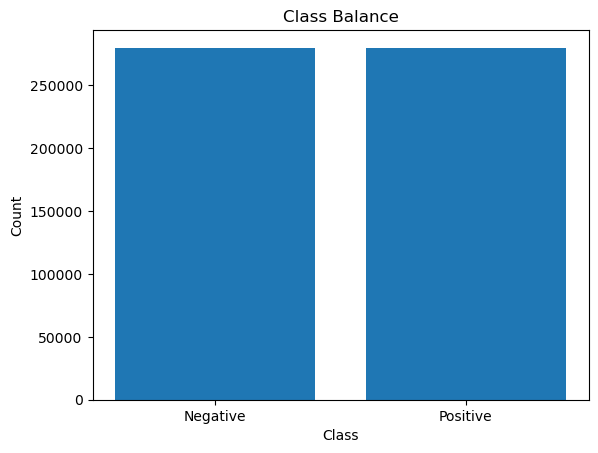

In [7]:
unique, count = np.unique(train_df.rating, return_counts=True)
plt.bar(["Negative" if i == 1 else "Positive" for i in unique], count)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

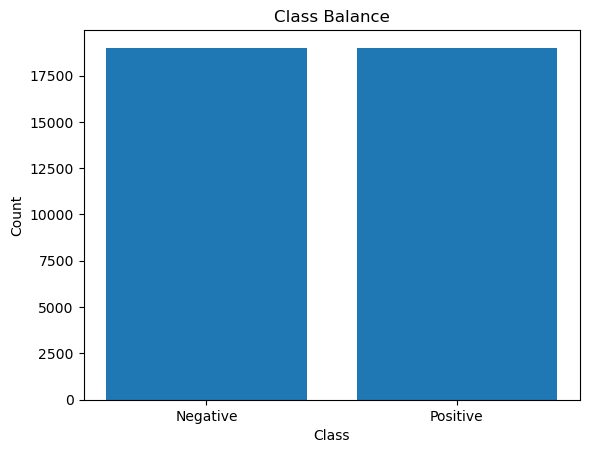

In [8]:
unique, count = np.unique(test_df.rating, return_counts=True)
plt.bar(["Negative" if i == 1 else "Positive" for i in unique], count)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

## Both above bar plots show that target variable 'rating' is well balanced with equal number of records for both positive and negative sentiments.

# No actions required to balance dataset to build better model.

In [9]:
def find_special_chars(sentence):
    """Function to find if a sentence contains any special chars.
    Returns 0 if no special chars are found and 1 if found.
    """
    spec_regex = re.compile('[@_!#$%^&*()<>?/\|}{~:]')
    if(spec_regex.search(sentence) == None):
        return 0
    return 1
    
special_count = 0
for review in train_df.review:
    special_count += find_special_chars(review)

print(f"Reviews with special characters: {special_count} out of {len(train_df.review)}")

Reviews with special characters: 410217 out of 560000


In [10]:
def contains_shorthand(sentence):
    """Function to find if a sentence contain any shorthand
    Return 1 if yes else no.
    """
    if "'" in sentence:
        return 1
    return 0
    
shorthand_count = 0
for review in train_df.review:
    shorthand_count += contains_shorthand(review)

print(f"Reviews with shorthands: {shorthand_count} out of {len(train_df.review)}")

Reviews with shorthands: 394763 out of 560000


In [11]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

def contains_stopwords(sentence, stopwords_list):
    """Function to find if a sentence contain any stopwords
    Return 1 if yes else 0.
    """
    for word in sentence.split(" "):
        if word.strip() in stopwords_list:
            return 1
    return 0

stopwords_count = 0
for review in train_df.review:
    stopwords_count += contains_stopwords(review, stopwords_list)

print(f"Reviews with stopwords: {stopwords_count} out of {len(train_df.review)}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ddurgoji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reviews with stopwords: 556099 out of 560000


In [12]:
def contains_link(sentence):
    """Function to find if a sentence contain any http(s) link(s)
    Returns 1 if yes else no.
    """
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(url_regex, sentence)
    if url:
        return 1
    return 0

links_count = 0
for review in train_df.review:
    links_count += contains_link(review)

print(f"Reviews with http(s) links: {links_count} out of {len(train_df.review)}")

Reviews with http(s) links: 2501 out of 560000


# Data preparation

In [13]:
train_df_fixed = train_df.copy(deep=True)

def case_convert():
    """Function to convert all letters to lower case
    """
    train_df_fixed.review = [i.lower() for i in train_df_fixed.review.values]

def remove_special_chars():
    """Function to remove special characters
    """
    train_df_fixed.review =  [re.sub(r"[^a-zA-Z]"," ",text) for text in train_df_fixed.review.values]
    
def remove_stopwords():
    """Function to remove stop words
    """
    reviews = []
    stopwords_list = stopwords.words('english')
    for item in train_df_fixed.review.values:
        string = ""
        for word in item.split(" "):
            if word.strip() in stopwords_list:
                continue
            else:
                string = string + " " + word
        reviews.append(string)
    train_df_fixed.review = reviews
        
def remove_links():
    """Function to remove http(s)links
    """
    reviews = []
    for review in train_df_fixed.review.values:
        remove_https = re.sub(r'http\S+', '', review)
        remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
        reviews.append(remove_com)
    train_df_fixed.review = reviews

def remove_accents():
    """Function to remove accents from reviews
    """
    train_df_fixed.review = [unidecode.unidecode(review) for review in train_df_fixed.review.values]

def normalize_spaces():
    """Function to normalize spaces
    """
    train_df_fixed.review = [re.sub(r"\s+"," ", review) for review in train_df_fixed.review.values]
    
def remove_shorthands():
    """Function to remove short hands in reviews
    """
    CONTRACTION_MAP = {
        "ain't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }
    reviews = []
    for review in train_df_fixed.review.values:
        string = ""
        for word in review.split(" "):
            if word.strip() in list(CONTRACTION_MAP.keys()):
                string = string + " " + CONTRACTION_MAP[word]
            else:
                string = string + " " + word
        reviews.append(string.strip())
    train_df_fixed.review = reviews

In [14]:
case_convert()
remove_links()
remove_shorthands()
remove_accents()
remove_special_chars()
remove_stopwords()
normalize_spaces()

In [15]:
train_df_fixed

rating                                             review
0            1   unfortunately frustration dr goldberg patient...
1            2   going dr goldberg years think one st patients...
2            1   know dr goldberg like moving arizona let tell...
3            1   writing review give heads see doctor office s...
4            2   food great best thing wings wings simply fant...
...        ...                                                ...
559995       2   ryan good everyone yelp claimed courteous kno...
559996       2   professional nfriendly non time affordable nw...
559997       1   phone calls always go voicemail messages retu...
559998       1   looks like good reviews gone head place jason...
559999       2   ryan rocks called morning sprinkler help pote...

[560000 rows x 2 columns]

In [16]:
links_count = 0
for review in train_df_fixed.review:
    links_count += contains_link(review)

print(f"Reviews with http(s) links: {links_count} out of {len(train_df_fixed.review)}")

stopwords_count = 0
for review in train_df_fixed.review:
    stopwords_count += contains_stopwords(review, stopwords_list)

print(f"Reviews with stopwords: {stopwords_count} out of {len(train_df_fixed.review)}")

shorthand_count = 0
for review in train_df_fixed.review:
    shorthand_count += contains_shorthand(review)

print(f"Reviews with shorthands: {shorthand_count} out of {len(train_df_fixed.review)}")

special_count = 0
for review in train_df_fixed.review:
    special_count += find_special_chars(review)

print(f"Reviews with special characters: {special_count} out of {len(train_df_fixed.review)}")

Reviews with http(s) links: 0 out of 560000
Reviews with stopwords: 0 out of 560000
Reviews with shorthands: 0 out of 560000
Reviews with special characters: 0 out of 560000


## All special characters, Stop words, Short hands, HTTP(S) links etc. are removed

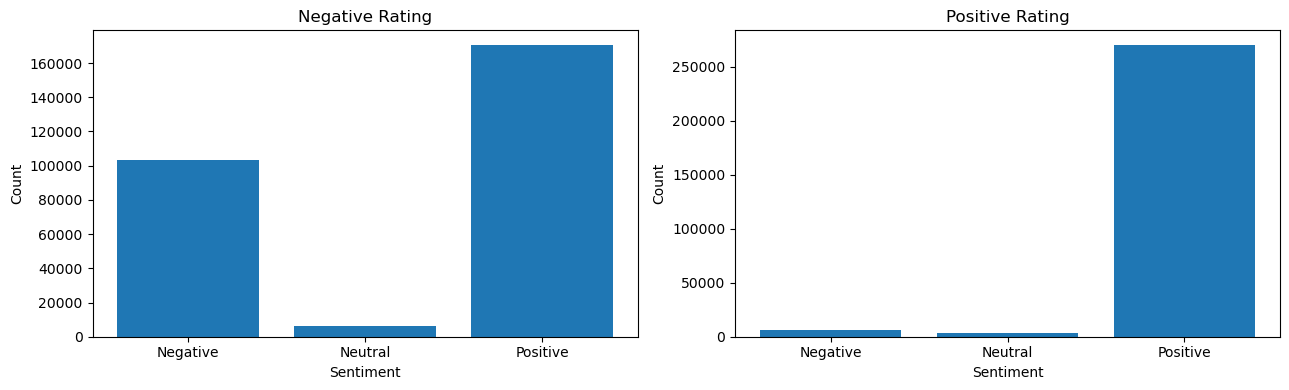

In [17]:
sentiment = []
for text in train_df_fixed.review.values:
    polarity = TextBlob(text).sentiment.polarity
    if polarity < 0:
        sentiment.append("Negative")
    elif polarity == 0:
        sentiment.append("Neutral")
    else:
        sentiment.append("Positive")
train_df_fixed["sentiment"] = sentiment
del sentiment

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
un, count = np.unique(train_df_fixed[train_df_fixed.rating == 1].sentiment, return_counts=True)
plt.bar(un, count)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Negative Rating")
plt.subplot(1,2,2)
un, count = np.unique(train_df_fixed[train_df_fixed.rating == 2].sentiment,return_counts=True)
plt.bar(un, count)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Positive Rating")
plt.tight_layout()

* First plot shows that Negative rating reviews have majority of positive sentiment than negative.
* Second plot shows that Positive rating reviews have majority positive sentiment reviews.
* Neutral sentiment reviews are very low in both plots

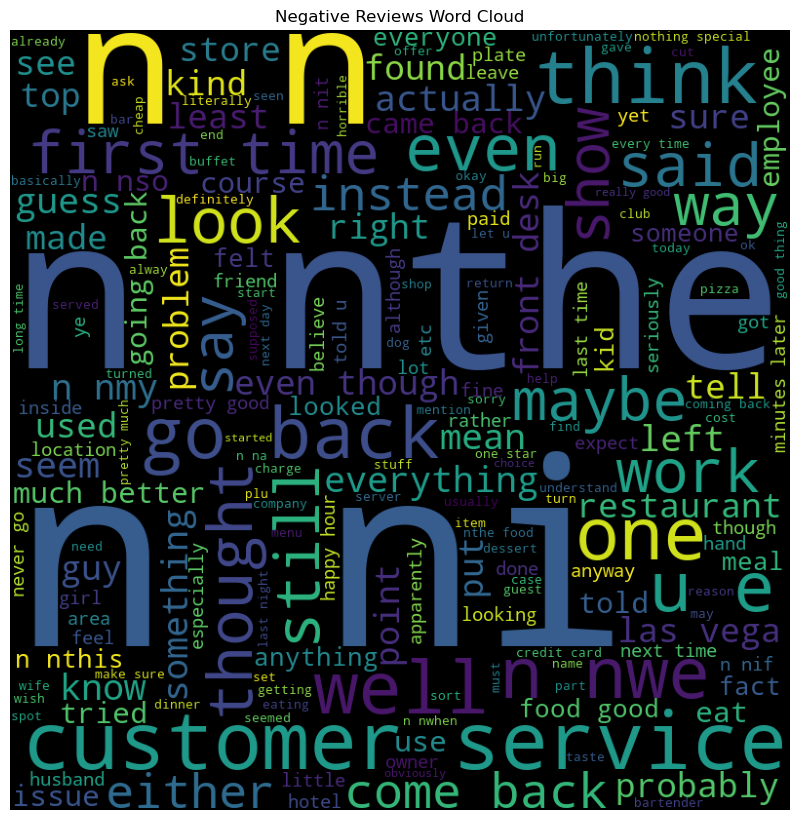

In [18]:
string = ""
for i in train_df_fixed[train_df_fixed.rating == 1].review:
    string = string + " " + i.strip()
    
wordcloud = WordCloud(
    width = 800,
    height = 800,
    background_color ='black',
    stopwords = set(STOPWORDS),
    min_font_size = 10
).generate(string)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.tight_layout(pad = 0)
 
plt.show()
del string

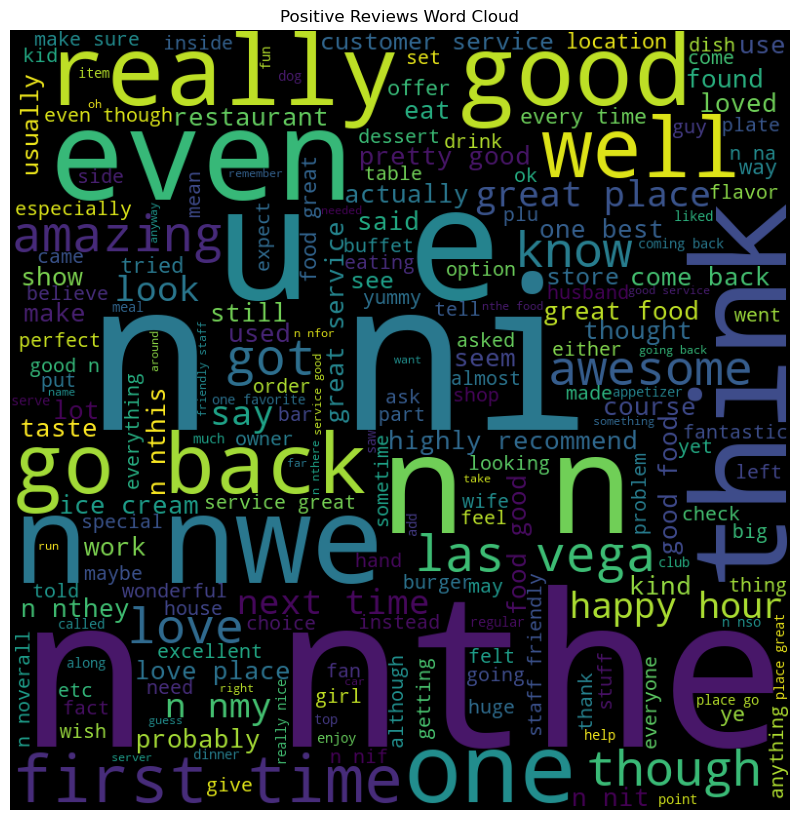

In [36]:
string = ""
for i in train_df_fixed[train_df_fixed.rating == 2].review:
    string = string + " " + i.strip()
    
wordcloud = WordCloud(
    width = 800,
    height = 800,
    background_color ='black',
    stopwords = set(STOPWORDS),
    min_font_size = 10
).generate(string)
 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.tight_layout(pad = 0)
 
plt.show()
del string

<Axes: xlabel='rating', ylabel='text_length'>

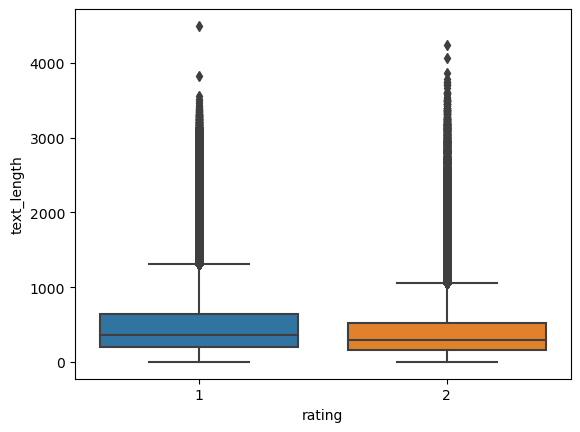

In [20]:
train_df_fixed['text_length'] = train_df_fixed['review'].apply(len)
sns.boxplot(x='rating', y='text_length', data=train_df_fixed)

## Above plot shows that for both positive and negative classes review text length is almost similar. 

# Modelling

### Splitting Training and Validation dataset

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df_fixed.review.values, 
    train_df_fixed.rating.values,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

In [ ]:
pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('mnb', MultinomialNB())
    ]
)

mnb_parameters = {
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
    'mnb__alpha': [0.0, 0.5, 1.0],
    'mnb__fit_prior': [True, False],
    'mnb__force_alpha': [True, False]
}

mnb_grid = RandomizedSearchCV(
    pipeline,
    mnb_parameters,
    scoring='accuracy',
    cv=5,
    n_jobs=1,
    verbose=10,
    n_iter=50
)
mnb_grid.fit(X_train, y_train)

In [ ]:
pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression())
    ]
)

log_reg_parameters = {
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
    'lr__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'lr__max_iter': [100, 200, 500, 1000],
    'lr__penalty': ['l1', 'l2', 'elasticnet', None]
}

log_reg_grid = RandomizedSearchCV(
    pipeline,
    log_reg_parameters,
    scoring='accuracy',
    cv=5,
    n_jobs=1,
    verbose=10,
    n_iter=50
)
log_reg_grid.fit(X_train, y_train)

In [ ]:
pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('dtree', DecisionTreeClassifier())
    ]
)

dtree_parameters = {
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
    'dtree__criterion': ['gini', 'entropy'],
    'dtree__max_depth': [4,5,6,7,8,9,10,11,12,15,20,30,40,50,60,70,80,90,100,1000],
    'dtree__min_samples_leaf': [5,10,15,20,25,30,40,50,60,70,80,90,100]
}

dtree_grid = RandomizedSearchCV(
    pipeline,
    dtree_parameters,
    scoring='accuracy',
    cv=5,
    n_jobs=1,
    verbose=10,
    n_iter=50
)
dtree_grid.fit(X_train, y_train)



In [ ]:
pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('rfc', RandomForestClassifier())
    ]
)

rfc_parameters = {
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
    'rfc__n_estimators': [100, 200, 300, 400, 500, 1000],
    'rfc__criterion': ['gini', 'entropy', 'log_loss'],
    'rfc__min_samples_leaf': [5,10,15,20,25,30,40,50,60,70,80,90,100]
}

rfc_grid = RandomizedSearchCV(
    pipeline,
    rfc_parameters,
    scoring='accuracy',
    cv=3,
    n_jobs=1,
    verbose=10,
    n_iter=3
)
rfc_grid.fit(X_train, y_train)




In [ ]:
pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('abc', AdaBoostClassifier())
    ]
)

abc_parameters = {
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__max_features': [100, 200, 500, 1000, 3000, 5000],
    'abc__n_estimators': [100, 200, 300, 400, 500, 1000],
    'abc__algorithm': ['SAMME', 'SAMME.R']
}

abc_grid = RandomizedSearchCV(
    pipeline,
    abc_parameters,
    scoring='accuracy',
    cv=3,
    n_jobs=1,
    verbose=10,
    n_iter=5
)
abc_grid.fit(X_train, y_train)



In [27]:
def evaluation(model, title):
    """Function to evaluate performance of a model
    """
    train_predict = model.predict(X_train)
    valid_predict = model.predict(X_valid)
    training_accuracy = accuracy_score(train_predict, y_train)*100
    test_accuracy = accuracy_score(valid_predict, y_valid)*100
    precision = precision_score(valid_predict, y_valid)*100
    recall = recall_score(valid_predict, y_valid)*100
    
    # Generate Confusion matrix
    cm = confusion_matrix(y_valid, model.predict(X_valid))
    disp = ConfusionMatrixDisplay(cm, display_labels=["Negative","Positive"])
    disp.plot(cmap="Blues", values_format='')
    plt.title(f"Confusion Matrix for {title}")
    plt.show()
    return training_accuracy, test_accuracy, precision, recall


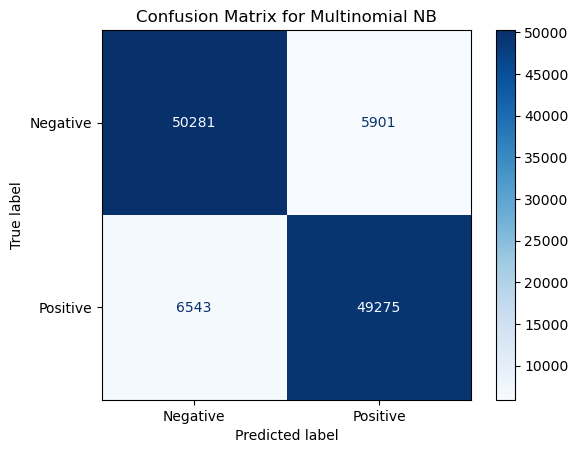

In [28]:
mnb_training_score, mnb_test_score, mnb_precision, mnb_recall = evaluation(
    mnb_grid.best_estimator_,
    "Multinomial NB"
)

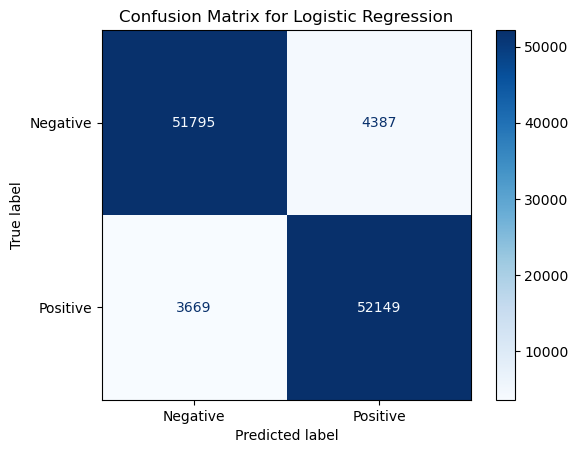

In [29]:
log_reg_training_score, log_reg_test_score, log_reg_precision, log_reg_recall = evaluation(
    log_reg_grid.best_estimator_,
    "Logistic Regression"
)

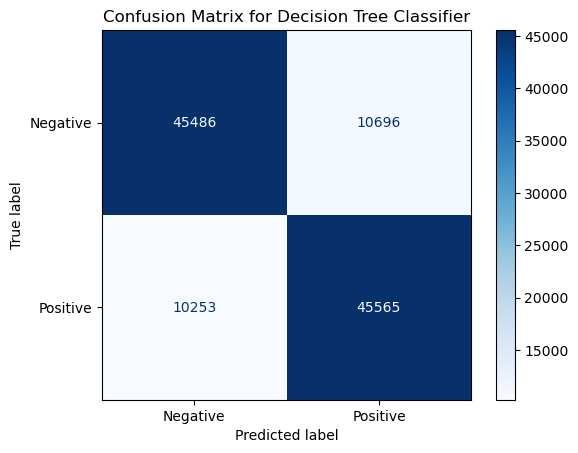

In [30]:
dtree_training_score, dtree_test_score, dtree_precision, dtree_recall = evaluation(
    dtree_grid.best_estimator_,
    "Decision Tree Classifier"
)

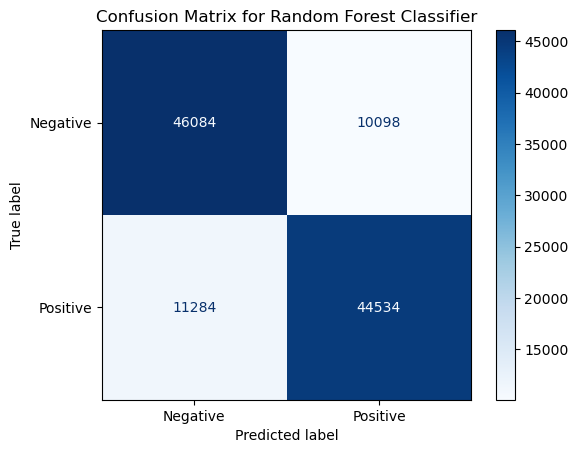

In [31]:
rfc_training_score, rfc_test_score, rfc_precision, rfc_recall = evaluation(
    rfc_grid.best_estimator_,
    "Random Forest Classifier"
)

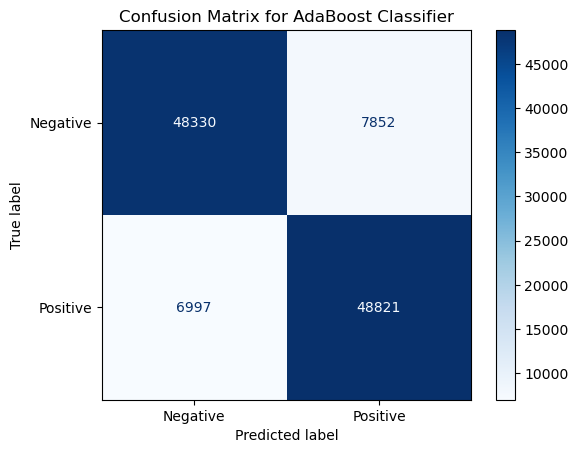

In [32]:
abc_training_score, abc_test_score, abc_precision, abc_recall = evaluation(
    abc_grid.best_estimator_,
    "AdaBoost Classifier"
)

# Evaluation

In [34]:
results = pd.DataFrame({
    'model': [
        'MultinomialNB',
        'LogisticRegression',
        'DecisionTreeClassifier',
        'RandomForestClassifier',
        'AdaBoostClassifier'
    ], 
    'best_params': [
        mnb_grid.best_params_,
        log_reg_grid.best_params_,
        dtree_grid.best_params_,
        rfc_grid.best_params_,
        abc_grid.best_params_
    ],
    'best_score': [
        mnb_test_score,
        log_reg_test_score,
        dtree_test_score,
        rfc_test_score,
        abc_test_score
    ]}).set_index('model')

In [35]:
pd.set_option('max_colwidth', None)
results

best_params  \
model                                                                                                                                                                                                                                                                               
MultinomialNB                            {'tfidf__use_idf': False, 'tfidf__sublinear_tf': False, 'tfidf__smooth_idf': False, 'tfidf__norm': 'l1', 'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 5000, 'mnb__force_alpha': True, 'mnb__fit_prior': True, 'mnb__alpha': 0.0}   
LogisticRegression                        {'tfidf__use_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__smooth_idf': False, 'tfidf__norm': None, 'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 5000, 'lr__solver': 'liblinear', 'lr__penalty': 'l1', 'lr__max_iter': 100}   
DecisionTreeClassifier  {'tfidf__use_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__smooth_idf': False, 'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 500, 'dtree__min_samples_leaf': 100, 'dtree__max_depth': 100, 'dtree__criterion': 'entropy'}   
RandomForestClassifier     {'tfidf__use_idf': False, 'tfidf__sublinear_tf': False, 'tfidf__smooth_idf': True, 'tfidf__norm': None, 'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 200, 'rfc__n_estimators': 100, 'rfc__min_samples_leaf': 20, 'rfc__criterion': 'log_loss'}   
AdaBoostClassifier                                        {'tfidf__use_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__smooth_idf': True, 'tfidf__norm': None, 'tfidf__ngram_range': (1, 2), 'tfidf__max_features': 500, 'abc__n_estimators': 300, 'abc__algorithm': 'SAMME.R'}   

                        best_score  
model                               
MultinomialNB            88.889286  
LogisticRegression       92.807143  
DecisionTreeClassifier   81.295536  
RandomForestClassifier   80.908929  
AdaBoostClassifier       86.741964

In [40]:
fig = px.bar(
    data_frame=results,
    x = results.index,
    y = results.best_score,
    opacity = 0.9,
    orientation = "v",
    barmode = 'group',
    title='Yelp sentiment analysis models performance - Best accuracy!',
)
fig.update_layout(xaxis_title='Models', yaxis_title='Value')

# Next steps for Module 24 Capstone part 2 week.

Right now, LogisticRegressor is performing better with about 93% accuracy on validation dataset.

* Find performance on test_df.
* Clean up the notebook and move around code blocks appropriately.
* Generate RandomForest and AdaBoostClassifiers with more n_iter's if possible.
* Generate models with CountVectorizer.
* Build a performance graph for various model thats generated.
* Deploy the model on DigitalOcean or any other cloud provider.
